# Training a nonlinear RNN with tensorflow

[Tensorflow](https://www.tensorflow.org/) is a popular framework for [deep learning](https://en.wikipedia.org/wiki/Deep_learning), which is the basis for many [recent and exciting advances](http://www.sciencemag.org/news/2017/07/how-ai-detectives-are-cracking-open-black-box-deep-learning) in artificial intelligence.

When all is said and done, Tensorflow is basically a really great tool for handling large and complex models and computing derivatives automatically, without doing the tedious math. This means that you can very rapidly prototype different model architectures, task parameters, and optimization approaches. Another big reason to use Tensorflow, or a similar deep learning framework (e.g. [PyTorch](http://pytorch.org/)), is that they seemlessly enable your model to run on GPUs, which are super fast for linear algebra operations but can be a huge pain to code by hand.

In this problem we will explore how to train a nonlinear recurrent neural network (RNN) to do a simple version of the classic random dots direction-discrimination task ([Britten et al., 1992](https://www.ncbi.nlm.nih.gov/pubmed/1464765)). In this task, a human or animal subject sees a screen of moving dots that are a mix of random motion and coherent motion to one direction (either left or right).
The goal is to estimate which direction the dots are moving, on average.
The task becomes arbitrarily hard as the random movements are cranked up and dominate over the coherent movements.
Click this link to [watch a rat perform](https://www.youtube.com/watch?v=oDxcyTn-0os) the task.

The basic philosophy here is to train a model network (by any means necessary) to solve a task similar to the one the animal is solving. Then, we can reverse-engineer how the network solves the task and hope that this sheds light on general computational mechanisms that may transfer to real neural circuits. See [Sussillo (2014)](https://doi.org/10.1016/j.conb.2014.01.008); [Mante, Sussillo et al. (2013)](https://doi.org/10.1038/nature12742); [Song et al. (2016)](https://doi.org/10.1371/journal.pcbi.1004792); [Orhan & Ma (2017)](https://doi.org/10.1038/s41467-017-00181-8) as further references on this approach.

#### Import standard python libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#### Code to generate a trial

Each trial consists of a 1-dimensional noisy time series. The input is either net positive or net negative, in analogy to the dots moving mostly to the right or the left in the behavioral task. The goal of the network is to produce 

In [2]:
# parameters for the stimulus
num_timesteps = 60
noise_stddev = 1.0

# function for generating trials
def generate_stimulus():
    """Generates a single trial.
        
    Returns:
        stimulus, numpy array/vector with size (num_timesteps,)
        target, {+1 or -1} the sign of the input (left or right dot motion)
    """
    target = np.random.choice([-1, +1])
    noise = np.random.randn(num_timesteps) * noise_stddev
    stimulus = target + noise
    return stimulus, np.sign(np.mean(stimulus))

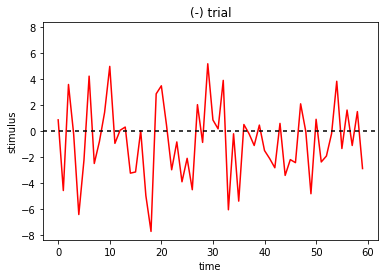

In [3]:
stim, targ = generate_stimulus()
if targ > 0:
    plt.plot(stim, '-k')
    plt.title('(+) trial')
if targ < 0:
    plt.plot(stim, '-r')
    plt.title('(-) trial')
plt.axhline(0, color='k', dashes=[2,2])
yl = np.max(np.abs(plt.ylim()))
plt.ylim([-yl, yl])
plt.ylabel('stimulus')
plt.xlabel('time')

In [4]:
import tensorflow as tf

# if you run this code block multiple times, this will clear all tensorflow
# variables so you don't eat up memory.
tf.reset_default_graph()

# structure of the network
num_neurons = 100
init_scale = .1

# synaptic weights
input_weights = tf.Variable(.1 * np.random.randn(1, num_neurons))
recurrent_weights = tf.Variable(.05 * np.random.randn(num_neurons, num_neurons))
output_weights = tf.Variable(.1 * np.random.randn(num_neurons, 1))

# input to the network
u = tf.placeholder(tf.float64, shape=num_timesteps)

# target for the network {+1 or -1}
s = tf.placeholder(tf.float64)

# initial condition
x0 = tf.zeros((1, num_neurons), tf.float64)

# simulate the network
x, y = [x0], []
for t in range(num_timesteps):
    x += [tf.nn.tanh(tf.matmul(x[-1], recurrent_weights) + u[t]*input_weights)]
    y.append(tf.matmul(x[-1], output_weights))

In [5]:
# create tensorflow session for simulation
sess = tf.Session()

# initialize all variables
sess.run(tf.global_variables_initializer())

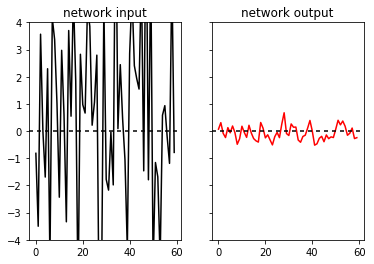

In [6]:
# run a trial
stim, targ = generate_stimulus()
out = sess.run(y, feed_dict={u: stim})
out = np.array(out).ravel()

# plot the results
fig, axes = plt.subplots(1, 2, sharey=True)

axes[0].plot(stim, color='k' if targ > 0 else 'r')
axes[0].axhline(color='k', dashes=[2,2])
axes[0].set_title('network input')
axes[0].set_ylim([-4, 4])

axes[1].plot(out, color='k' if out[-1] > 0 else 'r')
axes[1].axhline(color='k', dashes=[2,2])
axes[1].set_title('network output')

In [7]:
# define loss function (logistic)
loss_function = tf.log(1 + tf.exp(-s*y[-1]))

In [8]:
# this holds information about the optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate = 1e-3)

# this is the training operation/command sent to tensorflow
train_op = optimizer.minimize(loss_function)

trial 1999 / 2000

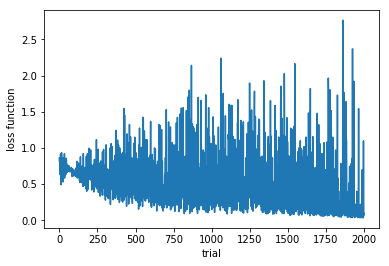

In [9]:
num_trials = 2000
opt_history = np.empty(num_trials)

for k in range(num_trials):
    print('\rtrial {} / {}'.format(k, num_trials), end='', flush=True)
    stim, targ = generate_stimulus()
    feed_dict = {
        u: stim,
        s: targ
    }
    opt_history[k], _ = sess.run([loss_function, train_op], feed_dict=feed_dict)

fig, ax = plt.subplots()
ax.plot(opt_history)
ax.set_ylabel('loss function')
ax.set_xlabel('trial')

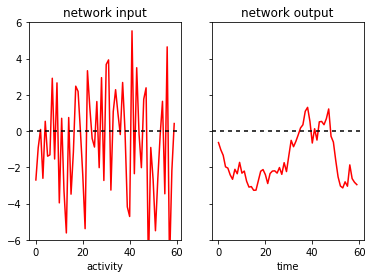

In [10]:
# run a trial
stim, targ = generate_stimulus()
out = sess.run(y, feed_dict={u: stim})
out = np.array(out).ravel()

# plot the results
fig, axes = plt.subplots(1, 2, sharey=True)

axes[0].plot(stim, color='k' if targ > 0 else 'r')
axes[0].axhline(color='k', dashes=[2,2])
axes[0].set_title('network input')
axes[0].set_ylim([-6, 6])
axes[0].set_xlabel('time')
axes[0].set_xlabel('activity')

axes[1].plot(out, color='k' if out[-1] > 0 else 'r')
axes[1].axhline(color='k', dashes=[2,2])
axes[1].set_title('network output')
axes[1].set_xlabel('time')

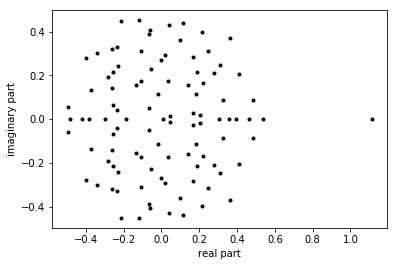

In [11]:
ev, evec = np.linalg.eig(sess.run(recurrent_weights))
plt.plot(np.real(ev), np.imag(ev), '.k')
plt.xlabel('real part')
plt.ylabel('imaginary part')

/Users/alex/anaconda/envs/tf/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


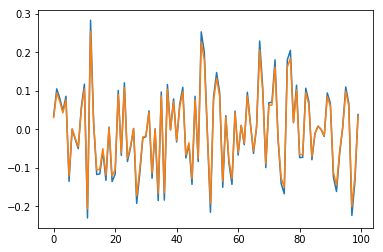

In [12]:
plt.plot(np.dot(sess.run(recurrent_weights), evec[:,0]))
plt.plot(evec[:,0])

In [13]:
np.argsort(evec[:,0])

array([11, 97, 51, 27, 34, 36, 75, 92, 55, 58, 45, 74, 19,  5, 98, 17, 32,
       91, 14, 20, 15, 28, 69, 57, 24, 47, 84, 43, 80, 81, 22, 60, 93, 65,
       16,  8, 25, 62, 44, 40, 73,  7, 29, 30, 88, 50, 85, 38, 87,  6, 33,
       26, 94, 18, 66, 86, 61, 64, 13, 78,  0, 56, 99, 59,  3, 31,  9, 41,
       96, 90, 70, 71, 83, 39,  2, 52,  4, 46, 89, 54, 63, 35, 21,  1, 82,
       68, 42, 95, 79, 37, 10, 23, 53, 76, 72, 49, 77, 67, 48, 12])